# Скачаем реализацию от авторов статьи

In [1]:
!git clone https://github.com/zhuchen03/gradinit.git

Cloning into 'gradinit'...
remote: Enumerating objects: 49, done.
remote: Counting objects: 100% (49/49), done.
remote: Compressing objects: 100% (39/39), done.
remote: Total 49 (delta 22), reused 27 (delta 9), pack-reused 0
Unpacking objects: 100% (49/49), done.


In [2]:
import os

os.chdir('./gradinit')
print(os.getcwd())

/content/gradinit


# Полезные функции для экспериментов

In [3]:
import time
import shutil

import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torchvision
import torch.optim as optim

def set_seed(seed):
    np.random.seed(seed)
    torch.manual_seed(seed)

def calc_parameters_count(net):
    return sum([p.numel() for p in model.parameters()])

def get_norms(model):
    result = []
    for n, p in model.named_parameters():
        result.append((n, p.norm().item()))
    return result

In [4]:
import torchvision.transforms as transforms

def get_train_transform():
    return transforms.Compose([
        transforms.RandomCrop(32, padding=4),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
    ])

def get_test_transform():
    return transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
    ])

In [5]:
import copy

def train_model(model, dataloaders, criterion, optimizer, scheduler, num_epochs=25,
                wide_batch=4, best_model_file='best.tc'):
    since = time.time()

    best_model_wts = model.state_dict()
    best_acc = 0.0

    epoch_loss_history = {'train': [], 'val': []}
    epoch_acc_history = {'train': [], 'val': []}

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train(True)  # Set model to training mode
                optimizer.zero_grad()
                passed = 0
            else:
                model.train(False)  # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0
            cnt = 0

            # Iterate over data.
            for data in dataloaders[phase]:
                # get the inputs
                inputs, labels = data

                inputs = inputs.cuda()
                labels = labels.cuda()

                # forward
                outputs = model(inputs)
                _, preds = torch.max(outputs, 1)
                loss = criterion(outputs, labels)

                # backward + optimize only if in training phase
                if phase == 'train':
                    loss.backward()
                    passed += 1
                    if passed == wide_batch:
                        torch.nn.utils.clip_grad_norm_(model.parameters(), 1e6)
                        optimizer.step()
                        optimizer.zero_grad()
                        passed = 0

                # statistics
                running_loss += loss.item()
                running_corrects += torch.sum(preds == labels).type(torch.float)
                cnt += len(labels)
            
            epoch_loss = running_loss / cnt
            epoch_acc = running_corrects / cnt
            
            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))
            epoch_loss_history[phase].append(epoch_loss)
            epoch_acc_history[phase].append(epoch_acc)

            if phase == 'train':
                train_acc = epoch_acc.item()
            else:
                val_acc = epoch_acc.item()
            
            if phase == 'val' and scheduler is not None:
                scheduler.step(epoch_loss)

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                print('New best accuracy: {:.4f} !'.format(epoch_acc))
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
                torch.save(best_model_wts, best_model_file)
        
        time_elapsed = time.time() - since
        print('Elapsed {:.0f}m {:.0f}s\n'.format(time_elapsed // 60, time_elapsed % 60))

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)

    return epoch_loss_history, epoch_acc_history

In [6]:
def group_weight(model, weight_decay):
    group_decay = []
    group_no_decay = []
    for m in model.modules():
        if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
            group_decay.append(m.weight)
            group_no_decay.append(m.bias)
        elif isinstance(m, nn.BatchNorm2d):
            group_no_decay.append(m.weight)
            group_no_decay.append(m.bias)
    assert len(list(model.parameters())) == len(group_decay) + len(group_no_decay)
    groups = [dict(params=group_decay, weight_decay=weight_decay),
              dict(params=group_no_decay, weight_decay=0.0)]
    return groups

# Дефолтное обучение

- Классификация на датасете CIFAR100
- Небольшая сверточная модель
- Инициализация xavier

In [7]:
from torchvision.datasets import CIFAR100

def get_cifar100_loaders(batch_size=64):
    train_dataset = CIFAR100('./data', train=True,
                         transform=get_train_transform(),
                         download=True)

    test_dataset = CIFAR100('./data', train=False,
                            transform=get_test_transform(),
                            download=True)
    
    train_dataloader = torch.utils.data.DataLoader(train_dataset,
                                                   batch_size=batch_size,
                                                   shuffle=True,
                                                   num_workers=2)

    test_dataloader = torch.utils.data.DataLoader(test_dataset,
                                                  batch_size=batch_size,
                                                  shuffle=True,
                                                  num_workers=2)
    
    return {'train': train_dataloader, 'val': test_dataloader}

In [8]:
from torchvision import models

def get_model1():
    model = nn.Sequential(
        nn.Conv2d(3, 32, kernel_size=(3, 3), padding='same'),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2),
        nn.Conv2d(32, 64, kernel_size=(3, 3), padding='same'),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2),
        nn.Conv2d(64, 128, kernel_size=(3, 3), padding='same'),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2),
        nn.Conv2d(128, 128, kernel_size=(3, 3), padding='same'),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2),
        nn.Flatten(),
        nn.Linear(512, 100)
    )
    return model.cuda()

In [9]:
def default_init(model):
    for m in model.modules():
        if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
            nn.init.xavier_normal_(m.weight)
            nn.init.normal_(m.bias, 0, 0.02)
        elif isinstance(m, nn.BatchNorm2d):
            nn.init.constant_(m.weight, 1.0)
            nn.init.constant_(m.bias, 0.0)

In [10]:
set_seed(1337)

model = get_model1()

model

Sequential(
  (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (1): ReLU()
  (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (4): ReLU()
  (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (6): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (7): ReLU()
  (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (9): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (10): ReLU()
  (11): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (12): Flatten(start_dim=1, end_dim=-1)
  (13): Linear(in_features=512, out_features=100, bias=True)
)

In [11]:
default_init(model)
get_norms(model)

[('0.weight', 2.3380239009857178),
 ('0.bias', 0.13010656833648682),
 ('3.weight', 6.578216075897217),
 ('3.bias', 0.15845812857151031),
 ('6.weight', 9.249512672424316),
 ('6.bias', 0.2240288257598877),
 ('9.weight', 11.295637130737305),
 ('9.bias', 0.2691660225391388),
 ('13.weight', 12.960747718811035),
 ('13.bias', 0.2084221988916397)]

In [12]:
calc_parameters_count(model)

292132

In [13]:
optimizer = optim.SGD(group_weight(model, 1e-3),
                      lr=0.01,
                      momentum=0.9,
                      nesterov=True)

default_loss_history, default_acc_history = train_model(model,
                                                        get_cifar100_loaders(),
                                                        nn.CrossEntropyLoss(),
                                                        optimizer,
                                                        None,
                                                        num_epochs=30)

  0%|          | 0/169001437 [00:00<?, ?it/s]

Extracting ./data/cifar-100-python.tar.gz to ./data
Files already downloaded and verified
Epoch 0/29
----------
train Loss: 0.0628 Acc: 0.0899
val Loss: 0.0549 Acc: 0.1609
New best accuracy: 0.1609 !
Elapsed 0m 26s

Epoch 1/29
----------
train Loss: 0.0516 Acc: 0.2050
val Loss: 0.0473 Acc: 0.2630
New best accuracy: 0.2630 !
Elapsed 0m 53s

Epoch 2/29
----------
train Loss: 0.0456 Acc: 0.2772
val Loss: 0.0430 Acc: 0.3182
New best accuracy: 0.3182 !
Elapsed 1m 19s

Epoch 3/29
----------
train Loss: 0.0415 Acc: 0.3289
val Loss: 0.0432 Acc: 0.3201
New best accuracy: 0.3201 !
Elapsed 1m 46s

Epoch 4/29
----------
train Loss: 0.0386 Acc: 0.3660
val Loss: 0.0372 Acc: 0.3858
New best accuracy: 0.3858 !
Elapsed 2m 12s

Epoch 5/29
----------
train Loss: 0.0365 Acc: 0.3954
val Loss: 0.0351 Acc: 0.4241
New best accuracy: 0.4241 !
Elapsed 2m 38s

Epoch 6/29
----------
train Loss: 0.0345 Acc: 0.4209
val Loss: 0.0365 Acc: 0.4028
Elapsed 3m 5s

Epoch 7/29
----------
train Loss: 0.0331 Acc: 0.4411
val 

## Добавим gradinit после нашей инициализации.

Выбираем $\eta = 10^{-2}$, так как используем такой learning rate. Тогда нам нужно выбрать $\gamma = \sqrt{10}$.

In [19]:
from gradinit_utils import gradinit

class DefaultArgs:
    gradinit_lr = 1e-3
    gradinit_iters = 1000
    gradinit_alg = 'sgd'
    gradinit_eta = 0.01               #learning rate we are going to use
    gradinit_min_scale = 0.01
    gradinit_grad_clip = 1
    gradinit_gamma = np.sqrt(10)
    gradinit_normalize_grad = False
    gradinit_resume = ''
    gradinit_bsize = -1
    batch_no_overlap = False
    expname = 'default'

In [15]:
set_seed(1337)
model = get_model1()
default_init(model)
init_norms = get_norms(model)

In [16]:
gradinit(model, get_cifar100_loaders(32)['train'], DefaultArgs())

Files already downloaded and verified
Files already downloaded and verified
Iter 10, obj iters 10, eta 1.000e-02, constraint count 0 loss: 4.603e+02 (4.619e+02), init loss: 4.653e+00 (4.640e+00), update loss 4.603e+00 (4.619e+00), total gnorm: 1.511e+00 (1.545e+00)	s_max: 1.01e+00	s_min: 9.90e-01	s_mean: 9.96e-01	s_weight_max: 9.94e-01	s_weight_min: 9.90e-01	s_weight_mean: 9.92e-01	
Iter 20, obj iters 20, eta 1.000e-02, constraint count 0 loss: 4.644e+02 (4.623e+02), init loss: 4.645e+00 (4.641e+00), update loss 4.644e+00 (4.623e+00), total gnorm: 1.321e+00 (1.506e+00)	s_max: 1.01e+00	s_min: 9.80e-01	s_mean: 9.91e-01	s_weight_max: 9.84e-01	s_weight_min: 9.80e-01	s_weight_mean: 9.82e-01	
Iter 30, obj iters 30, eta 1.000e-02, constraint count 0 loss: 4.645e+02 (4.621e+02), init loss: 4.647e+00 (4.639e+00), update loss 4.645e+00 (4.621e+00), total gnorm: 1.323e+00 (1.461e+00)	s_max: 1.01e+00	s_min: 9.72e-01	s_mean: 9.87e-01	s_weight_max: 9.76e-01	s_weight_min: 9.72e-01	s_weight_mean: 9.74

Функция `gradinit` от авторов выводит много дополнительной информации:

- loss до и после шага оптимизатора
- норму градиента шага оптимизатора
- минимальное/максимальное/среднее значение параметров $\alpha$

In [17]:
res_norms = get_norms(model)

In [10]:
def get_alphas(init_norms, res_norms):
    alphas = []
    for (a, b) in zip(init_norms, res_norms):
        assert a[0] == b[0]
        alphas.append((a[0], b[1] / max(a[1], 1e-12)))
    return alphas

In [19]:
get_alphas(init_norms, res_norms)

[('0.weight', 0.7266990795688889),
 ('0.bias', 1.0544589903180557),
 ('3.weight', 0.7162045878810359),
 ('3.bias', 0.7442420475185831),
 ('6.weight', 0.6879375598075518),
 ('6.bias', 0.8924456177598987),
 ('9.weight', 0.6669294364714808),
 ('9.bias', 1.0828464101992612),
 ('13.weight', 0.7095491948723243),
 ('13.bias', 0.8526959041971686)]

Выше преведены полученные значения для $\alpha$. Метод умножил все тензоры весов на константу примерно $0.7$.

In [20]:
optimizer = optim.SGD(group_weight(model, 1e-3),
                      lr=0.01,
                      momentum=0.9,
                      nesterov=True)

gradinit_loss_history, gradinit_acc_history = train_model(model,
                                                          get_cifar100_loaders(),
                                                          nn.CrossEntropyLoss(),
                                                          optimizer,
                                                          None,
                                                          num_epochs=30)

Files already downloaded and verified
Files already downloaded and verified
Epoch 0/29
----------
train Loss: 0.0654 Acc: 0.0659
val Loss: 0.0579 Acc: 0.1367
New best accuracy: 0.1367 !
Elapsed 0m 26s

Epoch 1/29
----------
train Loss: 0.0541 Acc: 0.1769
val Loss: 0.0492 Acc: 0.2396
New best accuracy: 0.2396 !
Elapsed 0m 52s

Epoch 2/29
----------
train Loss: 0.0479 Acc: 0.2490
val Loss: 0.0449 Acc: 0.2934
New best accuracy: 0.2934 !
Elapsed 1m 18s

Epoch 3/29
----------
train Loss: 0.0433 Acc: 0.3049
val Loss: 0.0418 Acc: 0.3270
New best accuracy: 0.3270 !
Elapsed 1m 44s

Epoch 4/29
----------
train Loss: 0.0401 Acc: 0.3487
val Loss: 0.0375 Acc: 0.3869
New best accuracy: 0.3869 !
Elapsed 2m 10s

Epoch 5/29
----------
train Loss: 0.0374 Acc: 0.3833
val Loss: 0.0361 Acc: 0.4016
New best accuracy: 0.4016 !
Elapsed 2m 36s

Epoch 6/29
----------
train Loss: 0.0352 Acc: 0.4106
val Loss: 0.0342 Acc: 0.4284
New best accuracy: 0.4284 !
Elapsed 3m 2s

Epoch 7/29
----------
train Loss: 0.0336 Ac

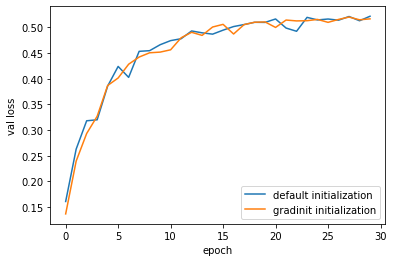

In [21]:
plt.xlabel('epoch')
plt.ylabel('val loss')
plt.plot(default_acc_history['val'], label='default initialization')
plt.plot(gradinit_acc_history['val'], label='gradinit initialization')
plt.legend()
plt.show()

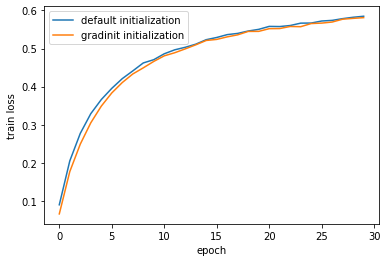

In [22]:
plt.xlabel('epoch')
plt.ylabel('train loss')
plt.plot(default_acc_history['train'], label='default initialization')
plt.plot(gradinit_acc_history['train'], label='gradinit initialization')
plt.legend()
plt.show()

Для используемой нами модели обучение итак было стабильным и инициализация стандартными методами также приводит к успеху.

Поэтому мы видим, что с и без использования gradinit обучение примерно одинаковое.

Из плюсов `gradinit` сейчас можно выделить то, что его очень легко применить (вызвать одну функцию). Однако добавляется некоторый набор гиперпараметров, которые тоже может быть полезно подобрать (например, слишком большой learning rate может привести к плохому обучению и инициализированная модель далее не будет учиться, я с этим столкнулся и в итоге взял learning rate $10^{-3}$).

# Как меняются alpha в зависимости от **seed**?

In [34]:
from contextlib import redirect_stdout

def mul(model, cf):
    for p in model.parameters():
        p.data.mul_(cf)

def get_alphas_list(init_norms, res_norms):
    lst = get_alphas(init_norms, res_norms)
    result = []
    for _, val in lst:
        result.append(val)
    return result

def generate_alphas(seed, cf):
    f = open('logs.txt', 'w')
    with redirect_stdout(f):
        set_seed(1337)
        model = get_model1()
        default_init(model)
        init_norms = get_norms(model)
        mul(model, cf)
        set_seed(seed)
        gradinit(model, get_cifar100_loaders(32)['train'], DefaultArgs())
        res_norms = get_norms(model)
        result = get_alphas_list(init_norms, res_norms)
    f.close()
    return result, model

In [35]:
default_alphas = get_alphas_list(init_norms, res_norms)

In [36]:
alphas_list = []
for i in range(10):
    print(f'iteration {i}')
    res, _ = generate_alphas(i, 1.0)
    alphas_list.append(res)

iteration 0
iteration 1
iteration 2
iteration 3
iteration 4
iteration 5
iteration 6
iteration 7
iteration 8
iteration 9


Модель инициализировалась с $10$-ю различными сидами.

Можно видеть, что разброс каждой координаты вектора $\alpha$ небольшой, то есть в целом метод сошелся к примерно одной и той же точке.

In [38]:
for x in alphas_list:
    print(x)

[0.7518625878675145, 1.0777674216818014, 0.7423052369396178, 0.704517843566052, 0.7075472194186156, 0.893938402268942, 0.68105728865802, 1.0759796065264695, 0.7219055550457977, 0.8344803169405369]
[0.7339642965199299, 1.080267964556039, 0.7273893791165088, 0.7164869199530371, 0.6968815372019083, 0.8689411958771663, 0.6690241089114846, 1.107536189424974, 0.7041985517789893, 0.8558067264999435]
[0.7272632529241414, 1.0719866127671194, 0.7192639870960998, 0.7085614510889421, 0.6907318696702908, 0.8868749634170352, 0.6630129224657123, 1.103234901286168, 0.7125134351052134, 0.897397200267077]
[0.7446275043509926, 1.0835614015959127, 0.7353796547995041, 0.7439794450695391, 0.7065285900331968, 0.8483920789234232, 0.6803979860750297, 1.0772829030329019, 0.7181532544208459, 0.8777043102308669]
[0.7433902999709475, 1.0637006797610071, 0.7345505449994306, 0.7075076088883289, 0.7009820888465057, 0.8813996908406898, 0.6716651607426809, 1.1087258862189266, 0.7161577177417854, 0.8516673045219135]
[0.

# Плохая изначальная инициализация

Допустим, что мы изначально плохо инициализировали модель. Просимулируем эту ситуацию домножением на $3$ относительно дефолтной инициализации.

Далее запустим `gradinit` и посмотрим, сможет ли он исправить нашу плохую инициализацию.

In [39]:
multiplied_alphas, model = generate_alphas(1337, 3.0)

In [42]:
multiplied_alphas

[0.7384188951216774,
 4.5236372482277565,
 0.7305014041153508,
 1.4376593070586692,
 0.6946596682873798,
 2.1151754119906987,
 0.6723508050347111,
 1.701927198085236,
 0.6679849325207653,
 1.7152055086670979]

Можно видеть, что все тензоры весов снова домножились на примерно $0.7$, а bias-ы домножились на довольно большие константы, но видимо это не так важно.

In [44]:
optimizer = optim.SGD(group_weight(model, 1e-3),
                      lr=0.01,
                      momentum=0.9,
                      nesterov=True)

gradinit_mul_loss_history, gradinit_mul_acc_history = train_model(model,
                                                                  get_cifar100_loaders(),
                                                                  nn.CrossEntropyLoss(),
                                                                  optimizer,
                                                                  None,
                                                                  num_epochs=30)

Files already downloaded and verified
Files already downloaded and verified
Epoch 0/29
----------
train Loss: 0.0653 Acc: 0.0641
val Loss: 0.0578 Acc: 0.1418
New best accuracy: 0.1418 !
Elapsed 0m 26s

Epoch 1/29
----------
train Loss: 0.0543 Acc: 0.1721
val Loss: 0.0492 Acc: 0.2387
New best accuracy: 0.2387 !
Elapsed 0m 52s

Epoch 2/29
----------
train Loss: 0.0477 Acc: 0.2504
val Loss: 0.0436 Acc: 0.3054
New best accuracy: 0.3054 !
Elapsed 1m 18s

Epoch 3/29
----------
train Loss: 0.0431 Acc: 0.3099
val Loss: 0.0412 Acc: 0.3374
New best accuracy: 0.3374 !
Elapsed 1m 44s

Epoch 4/29
----------
train Loss: 0.0397 Acc: 0.3487
val Loss: 0.0381 Acc: 0.3800
New best accuracy: 0.3800 !
Elapsed 2m 10s

Epoch 5/29
----------
train Loss: 0.0369 Acc: 0.3900
val Loss: 0.0364 Acc: 0.4022
New best accuracy: 0.4022 !
Elapsed 2m 36s

Epoch 6/29
----------
train Loss: 0.0349 Acc: 0.4143
val Loss: 0.0343 Acc: 0.4280
New best accuracy: 0.4280 !
Elapsed 3m 2s

Epoch 7/29
----------
train Loss: 0.0334 Ac

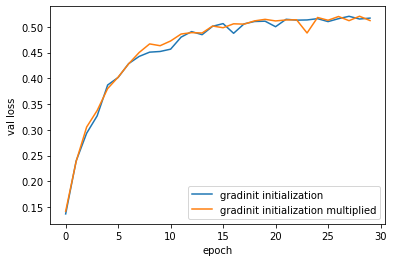

In [50]:
plt.xlabel('epoch')
plt.ylabel('val loss')
plt.plot(gradinit_acc_history['val'], label='gradinit initialization')
plt.plot(gradinit_mul_acc_history['val'], label='gradinit initialization multiplied')
plt.legend()
plt.show()

Модель снова обучилась хорошо. Значит, метод `gradinit` действительно помог исправить плохую инициализацию.

Проверим, что без `gradinit` после домножения обучение идет плохо:

In [53]:
set_seed(1337)
model = get_model1()
default_init(model)
mul(model, 3)

In [ ]:
optimizer = optim.SGD(group_weight(model, 1e-3),
                      lr=0.01,
                      momentum=0.9,
                      nesterov=True)

default_mul_loss_history, default_mul_acc_history = train_model(model,
                                                                get_cifar100_loaders(),
                                                                nn.CrossEntropyLoss(),
                                                                optimizer,
                                                                None,
                                                                num_epochs=30)

Files already downloaded and verified
Files already downloaded and verified
Epoch 0/29
----------
train Loss: 3.3218 Acc: 0.0095
val Loss: 0.0723 Acc: 0.0100
New best accuracy: 0.0100 !
Elapsed 0m 26s

Epoch 1/29
----------
train Loss: 0.0720 Acc: 0.0095
val Loss: 0.0723 Acc: 0.0100
Elapsed 0m 52s

Epoch 2/29
----------
train Loss: 0.0720 Acc: 0.0094
val Loss: 0.0723 Acc: 0.0100
Elapsed 1m 18s

Epoch 3/29
----------
train Loss: 0.0720 Acc: 0.0085
val Loss: 0.0723 Acc: 0.0100
Elapsed 1m 44s

Epoch 4/29
----------
train Loss: 0.0720 Acc: 0.0086
val Loss: 0.0723 Acc: 0.0100
Elapsed 2m 10s

Epoch 5/29
----------
train Loss: 0.0720 Acc: 0.0094
val Loss: 0.0723 Acc: 0.0100
Elapsed 2m 36s

Epoch 6/29
----------
train Loss: 0.0720 Acc: 0.0087
val Loss: 0.0723 Acc: 0.0100
Elapsed 3m 2s

Epoch 7/29
----------
train Loss: 0.0720 Acc: 0.0089
val Loss: 0.0723 Acc: 0.0100
Elapsed 3m 28s

Epoch 8/29
----------
train Loss: 0.0720 Acc: 0.0087
val Loss: 0.0723 Acc: 0.0100
Elapsed 3m 54s

Epoch 9/29
----

Так и есть.

Таким образом, действительно `gradinit` может помочь в ситуации, когда мы неверно инициализировали нашу модель и обучение не идет.

Сама процедура занимает очень мало времени (несоизмеримо с временем обучения). Если посмотреть на то, что происходило в `gradinit` во время последнего эксперимента, то можно увидеть, что половину итераций уменьшалась норма градиента, половину итераций уменьшалось значение лосса.

# Модель с batchnorm

In [22]:
def get_model2():
    model = nn.Sequential(
        nn.Conv2d(3, 32, kernel_size=(3, 3), padding='same'),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2),
        nn.Conv2d(32, 64, kernel_size=(3, 3), padding='same'),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2),
        nn.Conv2d(64, 128, kernel_size=(3, 3), padding='same'),
        nn.BatchNorm2d(128),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2),
        nn.Conv2d(128, 128, kernel_size=(3, 3), padding='same'),
        nn.BatchNorm2d(128),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2),
        nn.Flatten(),
        nn.Linear(512, 100)
    )
    return model.cuda()

In [23]:
set_seed(1337)

model = get_model2()

model

Sequential(
  (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (1): ReLU()
  (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (4): ReLU()
  (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (6): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (8): ReLU()
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (12): ReLU()
  (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (14): Flatten(start_dim=1, end_dim=-1)
  (15): Linear(in_features=512, out_features=100, bias=True)
)

In [24]:
calc_parameters_count(model)

292644

In [25]:
set_seed(1337)
model = get_model2()
default_init(model)

In [26]:
optimizer = optim.SGD(group_weight(model, 1e-3),
                      lr=0.01,
                      momentum=0.9,
                      nesterov=True)

default2_loss_history, default2_acc_history = train_model(model,
                                                          get_cifar100_loaders(),
                                                          nn.CrossEntropyLoss(),
                                                          optimizer,
                                                          None,
                                                          num_epochs=30)

Files already downloaded and verified
Files already downloaded and verified
Epoch 0/29
----------
train Loss: 0.0583 Acc: 0.1387
val Loss: 0.0501 Acc: 0.2214
New best accuracy: 0.2214 !
Elapsed 0m 17s

Epoch 1/29
----------
train Loss: 0.0469 Acc: 0.2588
val Loss: 0.0421 Acc: 0.3293
New best accuracy: 0.3293 !
Elapsed 0m 34s

Epoch 2/29
----------
train Loss: 0.0412 Acc: 0.3325
val Loss: 0.0393 Acc: 0.3640
New best accuracy: 0.3640 !
Elapsed 0m 51s

Epoch 3/29
----------
train Loss: 0.0376 Acc: 0.3799
val Loss: 0.0363 Acc: 0.4044
New best accuracy: 0.4044 !
Elapsed 1m 8s

Epoch 4/29
----------
train Loss: 0.0352 Acc: 0.4132
val Loss: 0.0347 Acc: 0.4265
New best accuracy: 0.4265 !
Elapsed 1m 24s

Epoch 5/29
----------
train Loss: 0.0332 Acc: 0.4409
val Loss: 0.0325 Acc: 0.4565
New best accuracy: 0.4565 !
Elapsed 1m 41s

Epoch 6/29
----------
train Loss: 0.0317 Acc: 0.4624
val Loss: 0.0309 Acc: 0.4710
New best accuracy: 0.4710 !
Elapsed 1m 58s

Epoch 7/29
----------
train Loss: 0.0302 Ac

In [29]:
set_seed(1337)
model = get_model2()
default_init(model)
init_norms = get_norms(model)
gradinit(model, get_cifar100_loaders(32)['train'], DefaultArgs())
res_norms = get_norms(model)
get_alphas(init_norms, res_norms)

Files already downloaded and verified
Files already downloaded and verified
Iter 10, obj iters 0, eta 1.000e-02, constraint count 10 loss: -1.000e+00 (-1.000e+00), init loss: 5.575e+00 (-1.000e+00), update loss -1.000e+00 (-1.000e+00), total gnorm: 1.042e+01 (1.091e+01)	s_max: 1.01e+00	s_min: 9.90e-01	s_mean: 1.00e+00	s_weight_max: 1.01e+00	s_weight_min: 9.90e-01	s_weight_mean: 1.00e+00	
Iter 20, obj iters 0, eta 1.000e-02, constraint count 20 loss: -1.000e+00 (-1.000e+00), init loss: 5.530e+00 (-1.000e+00), update loss -1.000e+00 (-1.000e+00), total gnorm: 1.029e+01 (1.066e+01)	s_max: 1.02e+00	s_min: 9.80e-01	s_mean: 1.00e+00	s_weight_max: 1.02e+00	s_weight_min: 9.80e-01	s_weight_mean: 1.01e+00	
Iter 30, obj iters 0, eta 1.000e-02, constraint count 30 loss: -1.000e+00 (-1.000e+00), init loss: 5.405e+00 (-1.000e+00), update loss -1.000e+00 (-1.000e+00), total gnorm: 9.731e+00 (1.044e+01)	s_max: 1.03e+00	s_min: 9.70e-01	s_mean: 1.01e+00	s_weight_max: 1.03e+00	s_weight_min: 9.70e-01	s_we

[('0.weight', 1.1649202361359943),
 ('0.bias', 1.0902269580809465),
 ('3.weight', 1.2008355031804168),
 ('3.bias', 1.0998406517994967),
 ('6.weight', 1.223375990598276),
 ('6.bias', 1.0436871105577106),
 ('7.weight', 1.1543372100286236),
 ('7.bias', 0.0),
 ('10.weight', 1.2225051230645392),
 ('10.bias', 1.0353382457290041),
 ('11.weight', 0.22257011402324298),
 ('11.bias', 0.0),
 ('15.weight', 0.14596488817496275),
 ('15.bias', 1.079777278884258)]

In [30]:
optimizer = optim.SGD(group_weight(model, 1e-3),
                      lr=0.01,
                      momentum=0.9,
                      nesterov=True)

gradinit2_loss_history, gradinit2_acc_history = train_model(model,
                                                            get_cifar100_loaders(),
                                                            nn.CrossEntropyLoss(),
                                                            optimizer,
                                                            None,
                                                            num_epochs=30)

Files already downloaded and verified
Files already downloaded and verified
Epoch 0/29
----------
train Loss: 0.0626 Acc: 0.0966
val Loss: 0.0539 Acc: 0.1789
New best accuracy: 0.1789 !
Elapsed 0m 16s

Epoch 1/29
----------
train Loss: 0.0488 Acc: 0.2343
val Loss: 0.0445 Acc: 0.2894
New best accuracy: 0.2894 !
Elapsed 0m 33s

Epoch 2/29
----------
train Loss: 0.0419 Acc: 0.3188
val Loss: 0.0393 Acc: 0.3601
New best accuracy: 0.3601 !
Elapsed 0m 49s

Epoch 3/29
----------
train Loss: 0.0378 Acc: 0.3742
val Loss: 0.0367 Acc: 0.3842
New best accuracy: 0.3842 !
Elapsed 1m 6s

Epoch 4/29
----------
train Loss: 0.0353 Acc: 0.4099
val Loss: 0.0340 Acc: 0.4375
New best accuracy: 0.4375 !
Elapsed 1m 22s

Epoch 5/29
----------
train Loss: 0.0331 Acc: 0.4421
val Loss: 0.0320 Acc: 0.4561
New best accuracy: 0.4561 !
Elapsed 1m 38s

Epoch 6/29
----------
train Loss: 0.0315 Acc: 0.4632
val Loss: 0.0318 Acc: 0.4692
New best accuracy: 0.4692 !
Elapsed 1m 55s

Epoch 7/29
----------
train Loss: 0.0303 Ac

Попробуем более долгое обучение `gradinit`

In [35]:
set_seed(1337)
model = get_model2()
default_init(model)
init_norms = get_norms(model)
args = DefaultArgs()
args.gradinit_iters = 10000
gradinit(model, get_cifar100_loaders(32)['train'], args)
res_norms = get_norms(model)
get_alphas(init_norms, res_norms)

Files already downloaded and verified
Files already downloaded and verified
Iter 10, obj iters 0, eta 1.000e-02, constraint count 10 loss: -1.000e+00 (-1.000e+00), init loss: 5.575e+00 (-1.000e+00), update loss -1.000e+00 (-1.000e+00), total gnorm: 1.042e+01 (1.091e+01)	s_max: 1.01e+00	s_min: 9.90e-01	s_mean: 1.00e+00	s_weight_max: 1.01e+00	s_weight_min: 9.90e-01	s_weight_mean: 1.00e+00	
Iter 20, obj iters 0, eta 1.000e-02, constraint count 20 loss: -1.000e+00 (-1.000e+00), init loss: 5.530e+00 (-1.000e+00), update loss -1.000e+00 (-1.000e+00), total gnorm: 1.029e+01 (1.066e+01)	s_max: 1.02e+00	s_min: 9.80e-01	s_mean: 1.00e+00	s_weight_max: 1.02e+00	s_weight_min: 9.80e-01	s_weight_mean: 1.01e+00	
Iter 30, obj iters 0, eta 1.000e-02, constraint count 30 loss: -1.000e+00 (-1.000e+00), init loss: 5.405e+00 (-1.000e+00), update loss -1.000e+00 (-1.000e+00), total gnorm: 9.731e+00 (1.044e+01)	s_max: 1.03e+00	s_min: 9.70e-01	s_mean: 1.01e+00	s_weight_max: 1.03e+00	s_weight_min: 9.70e-01	s_we

[('0.weight', 1.0298860446303189),
 ('0.bias', 1.048618281988578),
 ('3.weight', 1.0557799963886825),
 ('3.bias', 1.369907122897476),
 ('6.weight', 1.1752597187174973),
 ('6.bias', 1.02652344768503),
 ('7.weight', 1.5962808945887914),
 ('7.bias', 0.0),
 ('10.weight', 1.1752092714575566),
 ('10.bias', 0.9984158039323758),
 ('11.weight', 0.9522981117452901),
 ('11.bias', 0.0),
 ('15.weight', 0.010000000506375582),
 ('15.bias', 0.46779618648462595)]

In [36]:
optimizer = optim.SGD(group_weight(model, 1e-3),
                      lr=0.01,
                      momentum=0.9,
                      nesterov=True)

gradinit2_long_loss_history, gradinit2_long_acc_history = train_model(model,
                                                                      get_cifar100_loaders(),
                                                                      nn.CrossEntropyLoss(),
                                                                      optimizer,
                                                                      None,
                                                                      num_epochs=30)

Files already downloaded and verified
Files already downloaded and verified
Epoch 0/29
----------
train Loss: 0.0552 Acc: 0.1665
val Loss: 0.0466 Acc: 0.2741
New best accuracy: 0.2741 !
Elapsed 0m 17s

Epoch 1/29
----------
train Loss: 0.0435 Acc: 0.3004
val Loss: 0.0396 Acc: 0.3531
New best accuracy: 0.3531 !
Elapsed 0m 34s

Epoch 2/29
----------
train Loss: 0.0386 Acc: 0.3644
val Loss: 0.0364 Acc: 0.3957
New best accuracy: 0.3957 !
Elapsed 0m 51s

Epoch 3/29
----------
train Loss: 0.0355 Acc: 0.4069
val Loss: 0.0383 Acc: 0.3827
Elapsed 1m 8s

Epoch 4/29
----------
train Loss: 0.0334 Acc: 0.4374
val Loss: 0.0328 Acc: 0.4481
New best accuracy: 0.4481 !
Elapsed 1m 25s

Epoch 5/29
----------
train Loss: 0.0316 Acc: 0.4645
val Loss: 0.0319 Acc: 0.4650
New best accuracy: 0.4650 !
Elapsed 1m 42s

Epoch 6/29
----------
train Loss: 0.0302 Acc: 0.4845
val Loss: 0.0309 Acc: 0.4780
New best accuracy: 0.4780 !
Elapsed 1m 60s

Epoch 7/29
----------
train Loss: 0.0292 Acc: 0.4983
val Loss: 0.0306 A

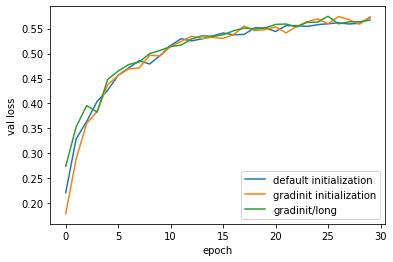

In [37]:
plt.xlabel('epoch')
plt.ylabel('val loss')
plt.plot(default2_acc_history['val'], label='default initialization')
plt.plot(gradinit2_acc_history['val'], label='gradinit initialization')
plt.plot(gradinit2_long_acc_history['val'], label='gradinit/long')
plt.legend()
plt.show()

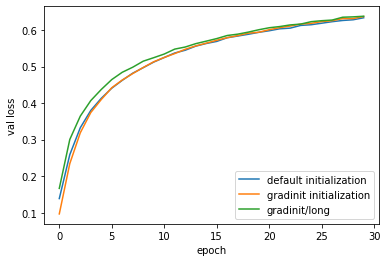

In [38]:
plt.xlabel('epoch')
plt.ylabel('val loss')
plt.plot(default2_acc_history['train'], label='default initialization')
plt.plot(gradinit2_acc_history['train'], label='gradinit initialization')
plt.plot(gradinit2_long_acc_history['train'], label='gradinit/long')
plt.legend()
plt.show()

# Выводы

- `gradinit` очень быстрая и практически бесплатная процедура, которую можно использовать перед обучением. Единственный минус: возможно немножко нужно будет повозиться с гиперпараметрами
- метод не проигрывает другим инициализациям
- метод может исправить изначальную плохую инициализацию
- можно использовать много итераций для инициализации